In [1]:
import os
import sys
import json

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from scipy.stats import shapiro, f_oneway
from sklearn.metrics import classification_report, confusion_matrix

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(os.path.join(module_path))

from functions.plotting import plot_bars, plot_bar_from_dict

WIDTH = 150
HEIGHT = 150

In [2]:
data_dir = os.path.join(
    '..',
    '..',
    '..',
    'data1',
    'images_original_inception_resnet_v2_150x150_categorized')
test_data_dir = os.path.join(data_dir, 'validation')
test_ds = keras.utils.image_dataset_from_directory(
    directory=test_data_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(HEIGHT, WIDTH))

Found 2000 files belonging to 7 classes.


In [3]:
ROOT_NAME = 'inception_dealing_with_imbalance_using'
models_dir = os.path.join(
    '..',
    '..',
    'models',
    'data1')
model_file_names = \
    list(
        filter(
            lambda model_file_name: ROOT_NAME in model_file_name,
            os.listdir(models_dir)))

In [4]:
def get_accuracies_and_losses(models: list[str]) -> (dict[str, float], dict[str, float]):
    accuracies = {}
    losses = {}

    for model_name in models:
        model_path = os.path.join(models_dir, model_name)
        model = keras.models.load_model(model_path)
        loss, _, _, accuracy, _, _ = model.evaluate(test_ds)
        accuracies[model_name] = accuracy
        losses[model_name] = loss

    return accuracies, losses

In [5]:
accuracies_file = os.path.join('..', '..', 'histories', f'{ROOT_NAME}_accuracies.json')
losses_file = os.path.join('..', '..', 'histories', f'{ROOT_NAME}_losses.json')

In [6]:
if not os.path.exists(accuracies_file):
    accuracies, losses = get_accuracies_and_losses(model_file_names)

    with open(accuracies_file, 'w') as json_file:
        json.dump(accuracies, json_file, indent=4)
    with open(losses_file, 'w') as json_file:
        json.dump(losses, json_file, indent=4)

In [7]:
with open(accuracies_file, 'r') as accuracies_file_handle:
    accuracies = json.load(accuracies_file_handle)
with open(losses_file, 'r') as losses_file_handle:
    losses = json.load(losses_file_handle)

In [ ]:
root = os.path.join('..', '..', 'plots', 'testing')
accuracies_pdf_path = os.path.join(root, f'{ROOT_NAME}_accuracies.pdf')

plot_bar_from_dict(accuracies, 'Model Accuracies', 'Name', 'Accuracy', accuracies_pdf_path)

In [ ]:
losses_pdf_path = os.path.join(root, f'{ROOT_NAME}_losses.pdf')

plot_bar_from_dict(losses, 'Model Losses', 'Name', 'Accuracy', losses_pdf_path)

Analysis part of model testing:

In [15]:
model_categories = set(map(lambda name: '_'.join(name.split('_')[:-2]), model_file_names))
grouped_models = {key: list(filter(lambda name: name.startswith(key), model_file_names)) for key in model_categories}
keyed_accuracies = {key: [] for key in grouped_models}
keyed_losses = {key: [] for key in grouped_models}


def categorize_numbers(for_dict: dict[str, list[float]], numbers_dict: dict[str, float]) -> None:
    for group, value in for_dict.items():
        vals = [
            value for key, value in numbers_dict.items()
            if key.startswith(group)]

        value.extend(vals)


categorize_numbers(keyed_accuracies, accuracies)
categorize_numbers(keyed_losses, losses)

In [16]:
ALPHA = .05
anova_testable_groups = []
kruskal_walis_testable_groups = []


def assign_models_to_groups(models: list[float], col: str) -> None:
    _, p_value = shapiro(models)

    if p_value >= ALPHA:
        anova_testable_groups.append(col)
    else:
        kruskal_walis_testable_groups.append(col)


first_col = next(iter(keyed_accuracies))
second_col = next(iter(keyed_accuracies))

assign_models_to_groups(keyed_accuracies[first_col], first_col)
assign_models_to_groups(keyed_accuracies[second_col], second_col)

Only normal distributed outcomes here, so let's go with anova tests

In [17]:
anova_values = []
anova_cols = []

for col in anova_testable_groups:
    if col in keyed_accuracies:
        anova_values.append(keyed_accuracies[col])
        anova_cols.append(col)


f_stat_anova, p_value_anova = f_oneway(*anova_values)

print(f'ANOVA p-value: {p_value_anova}')

ANOVA p-value: 1.0


The models are the same and the differentiating factor is that one was trained for 100 epochs max and the other for 200 epochs max. Therefore, it makes sense that the p-value is big: 1.0 - a null hypothesis should not be rejected.

Out of all the tries one result stood out, so that one will be picked for evaluation.

In [18]:
name = ''
best_acc = 0

for key, value in accuracies.items():
    if '3_whole_model_trainable_with_attention_module_on_top' in key and value > best_acc:
        name = key
        best_acc = value

model_path = os.path.join(models_dir, name)
model = keras.models.load_model(model_path)
y_pred_labels = model.predict(test_ds)

63/63 [==============================] - 11s 61ms/step


              precision    recall  f1-score   support

       akiec       0.04      0.05      0.04        65
         bcc       0.06      0.07      0.06       102
         bkl       0.12      0.11      0.11       219
          df       0.00      0.00      0.00        23
         mel       0.14      0.06      0.09       222
          nv       0.68      0.75      0.71      1341
        vasc       0.08      0.07      0.07        28

    accuracy                           0.53      2000
   macro avg       0.16      0.16      0.16      2000
weighted avg       0.49      0.53      0.51      2000



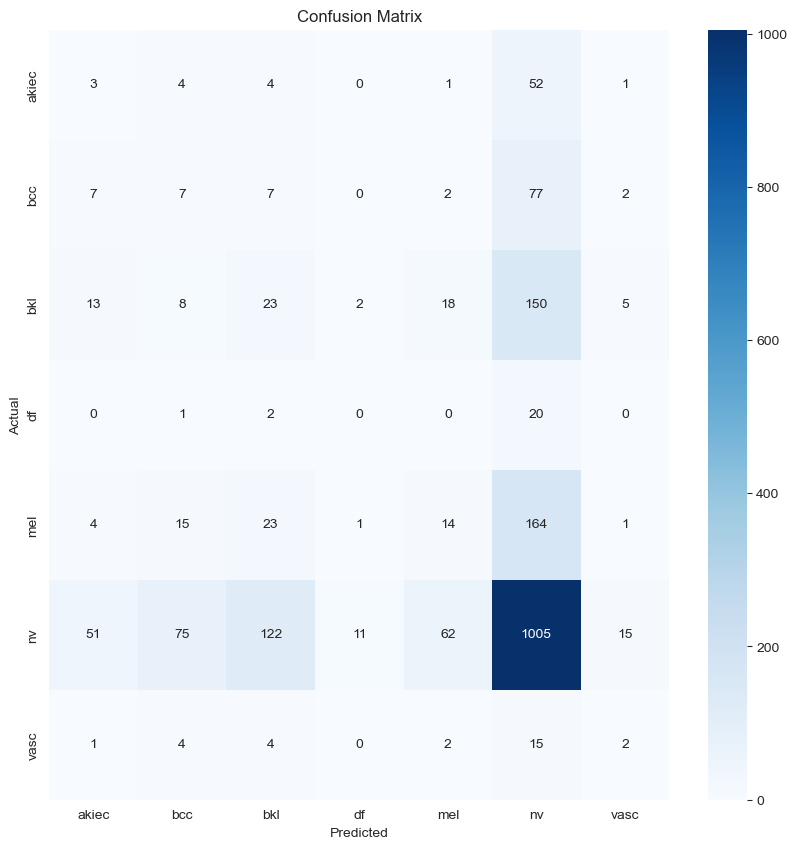

In [21]:
y_pred_labels = np.argmax(y_pred_labels, axis=1)
y_test = []

for _, labels in test_ds:
    y_test.extend(np.argmax(labels.numpy(), axis=-1))

y_test = np.array(y_test)
report = classification_report(y_test, y_pred_labels, target_names=test_ds.class_names, zero_division=0)
print(report)

cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_ds.class_names, yticklabels=test_ds.class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

It's very visible that the model despite having over 81% accuracy, still gets confused a lot by the classes that are not often encountered in the dataset, although it's slightly better than the model that is ignoring the imbalance.